In [1]:
import cv2
import os
import numpy as np
import seaborn as sns
import torch
import wandb
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import models
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from albumentations import (
    Compose, RandomRotate90, Flip, Transpose, OneOf, 
    CLAHE, RandomBrightnessContrast, RandomGamma, GaussNoise, ShiftScaleRotate,RandomResizedCrop
)
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision import models
from torch.optim.lr_scheduler import ReduceLROnPlateau
from efficientnet_pytorch import EfficientNet
%matplotlib inline

In [2]:
# Define the label mapping
LABEL_MAPPING = {
    0: "No DR",
    1: "Mild",
    2: "Moderate",
    3: "Severe",
    4: "Proliferative DR"
}

In [3]:
# Image preprocessing function
def preprocess_image(image_path, size=299):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Resize
    image = cv2.resize(image, (size, size))
    
    # Circular crop
    mask = np.zeros(image.shape[:2], dtype=np.uint8)
    cv2.circle(mask, (size//2, size//2), size//2, (255, 255, 255), -1)
    image = cv2.bitwise_and(image, image, mask=mask)
    
    # CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    lab[:,:,0] = clahe.apply(lab[:,:,0])
    image = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
    
    # Gaussian blur for noise reduction
    image = cv2.GaussianBlur(image, (5, 5), 0)
    
    # Vessel enhancement (simple method)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    image = cv2.addWeighted(image, 1, cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB), 0.2, 0)
    
    return image

# Augmentation pipeline
def create_augmentations():
    return Compose([
        RandomRotate90(),
        Flip(),
        Transpose(),
        OneOf([
            CLAHE(clip_limit=2),
            RandomBrightnessContrast(),
            RandomGamma()
        ], p=0.3),
        GaussNoise(var_limit=(10.0, 50.0)),
    ])

In [4]:
# Custom Dataset
class DRDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = preprocess_image(self.image_paths[idx])
        label = self.labels[idx]
        
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        
        return torch.FloatTensor(image.transpose(2, 0, 1)), torch.LongTensor([label])[0]

    def get_label_description(self, idx):
        return LABEL_MAPPING[self.labels[idx]]


# Load and preprocess data
def load_data_paths(data_dir):
    image_paths = []
    labels = []
    for class_folder in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_folder)
        if os.path.isdir(class_path):
            label = int(class_folder)
            for image_file in os.listdir(class_path):
                image_path = os.path.join(class_path, image_file)
                image_paths.append(image_path)
                labels.append(label)
    return image_paths, labels

In [5]:
# Oversampling function
def oversample_minority_classes(image_paths, labels):
    classes, class_counts = np.unique(labels, return_counts=True)
    max_size = max(class_counts)
    oversampled_paths, oversampled_labels = [], []
    
    for cls in classes:
        cls_indices = np.where(np.array(labels) == cls)[0]
        cls_paths = [image_paths[i] for i in cls_indices]
        cls_labels = [labels[i] for i in cls_indices]
        
        if len(cls_paths) < max_size:
            resampled_paths, resampled_labels = resample(cls_paths, cls_labels,
                                                         n_samples=max_size,
                                                         random_state=42)
        else:
            resampled_paths, resampled_labels = cls_paths, cls_labels
        
        oversampled_paths.extend(resampled_paths)
        oversampled_labels.extend(resampled_labels)
    
    return oversampled_paths, oversampled_labels
# Calculate class weights
def calculate_class_weights(labels):
    class_counts = np.bincount(labels)
    total_samples = len(labels)
    class_weights = total_samples / (len(class_counts) * class_counts)
    return torch.FloatTensor(class_weights)

In [6]:
# Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt)**self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [7]:
# Load and preprocess data
data_dir = 'raw_data'
image_paths, labels = load_data_paths(data_dir)


# Split the data
X_train, X_test, y_train, y_test =train_test_split(image_paths, labels, test_size=0.2, stratify=labels, random_state=42)
 


In [8]:
# Oversample the training data
X_train_resampled, y_train_resampled = oversample_minority_classes(X_train, y_train)

# Calculate class weights
class_weights = calculate_class_weights(y_train_resampled)

In [9]:
# Create datasets
train_transform = create_augmentations()
train_dataset = DRDataset(X_train_resampled, y_train_resampled, transform=train_transform)
test_dataset = DRDataset(X_test, y_test)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

/var/folders/8z/r8b3qfps3_595xgv29gb_k_h0000gn/T/ipykernel_62918/3968447104.py:34: DeprecationWarning: Flip is deprecated. Consider using HorizontalFlip, VerticalFlip, RandomRotate90 or D4.
  Flip(),


In [11]:
# Print some information about the data
print(f"Original training set size: {len(X_train)}")
print(f"Resampled training set size: {len(X_train_resampled)}")
print(f"Test set size: {len(X_test)}")
print(f"Class weights: {class_weights}")

Original training set size: 28100
Resampled training set size: 103240
Test set size: 7026
Class weights: tensor([1., 1., 1., 1., 1.])


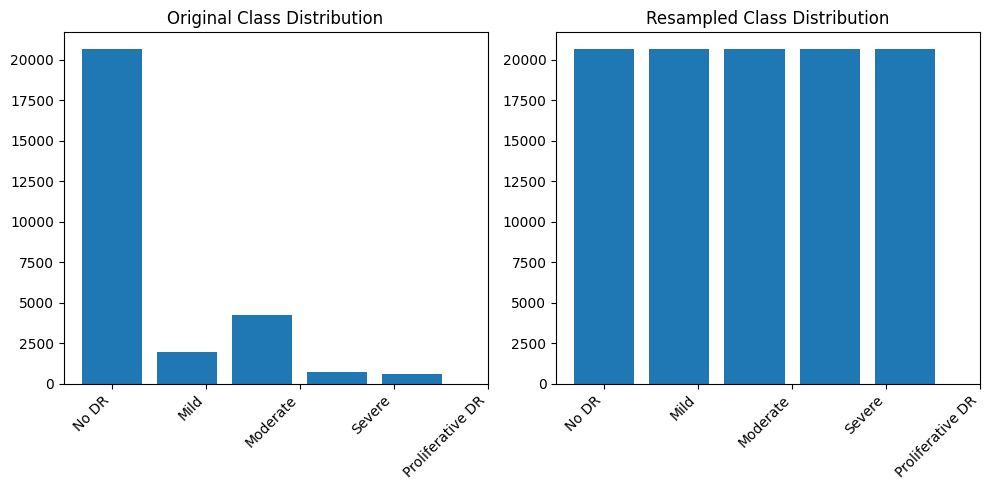

In [12]:
# Visualize class distribution
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Class Distribution")
plt.hist(y_train, bins=5, align='left', rwidth=0.8)
plt.xticks(range(5), [LABEL_MAPPING[i] for i in range(5)], rotation=45, ha='right')
plt.subplot(1, 2, 2)
plt.title("Resampled Class Distribution")
plt.hist(y_train_resampled, bins=5, align='left', rwidth=0.8)
plt.xticks(range(5), [LABEL_MAPPING[i] for i in range(5)], rotation=45, ha='right')
plt.tight_layout()
plt.show()

Training Images:


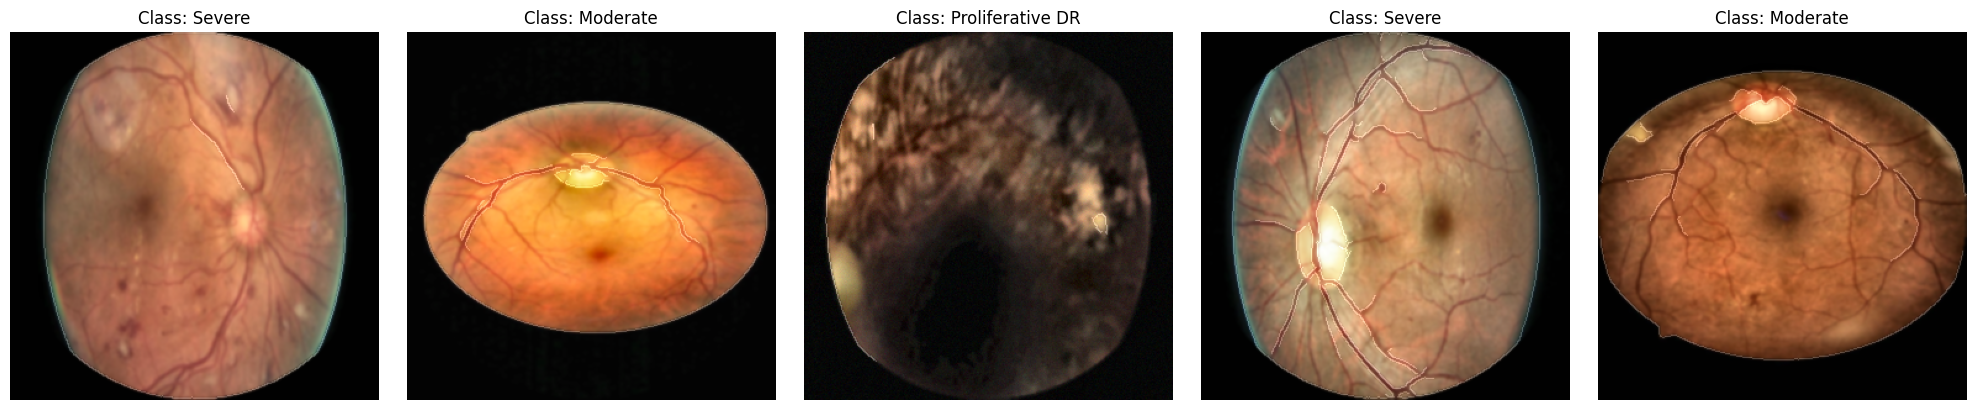


Test Images:


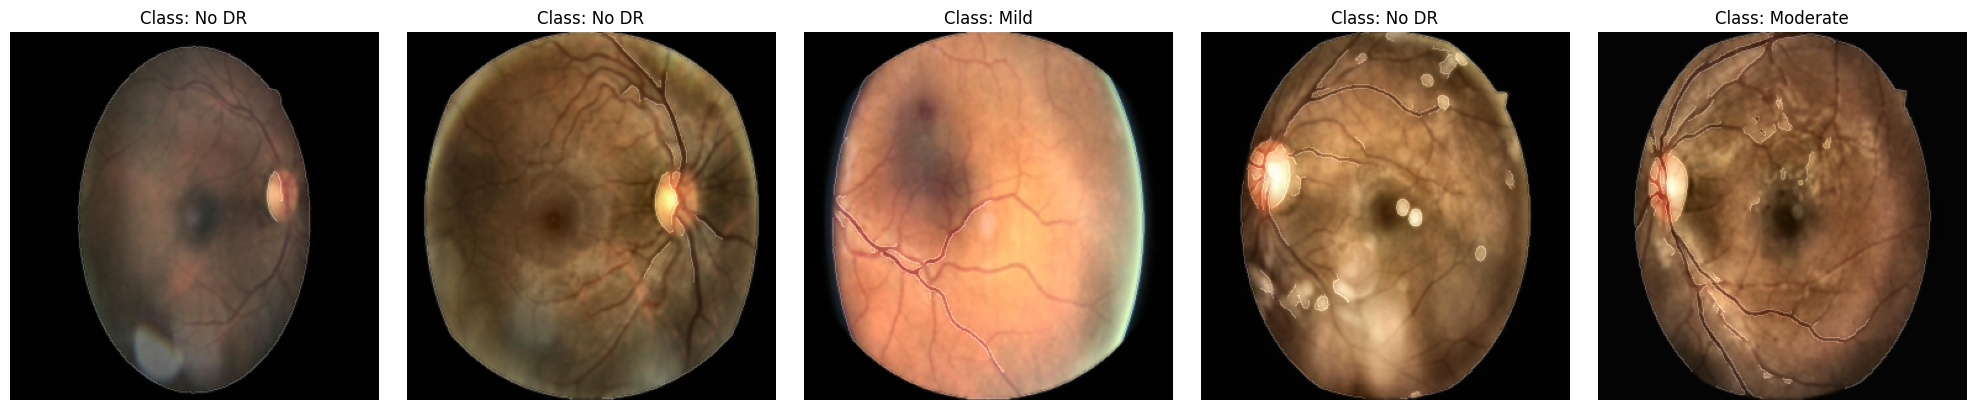

In [13]:
def show_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 4))
    for i in range(num_images):
        idx = np.random.randint(len(dataset))
        img, label = dataset[idx]
        img = img.numpy().transpose(1, 2, 0)  # Convert from CHW to HWC format
        
        # Normalize image for display
        img = (img - img.min()) / (img.max() - img.min())
        
        axes[i].imshow(img)
        axes[i].set_title(f"Class: {LABEL_MAPPING[label.item()]}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

# Visualize training images
print("Training Images:")
show_images(train_dataset)

# Visualize test images
print("\nTest Images:")
show_images(test_dataset)

Augmentation Examples:


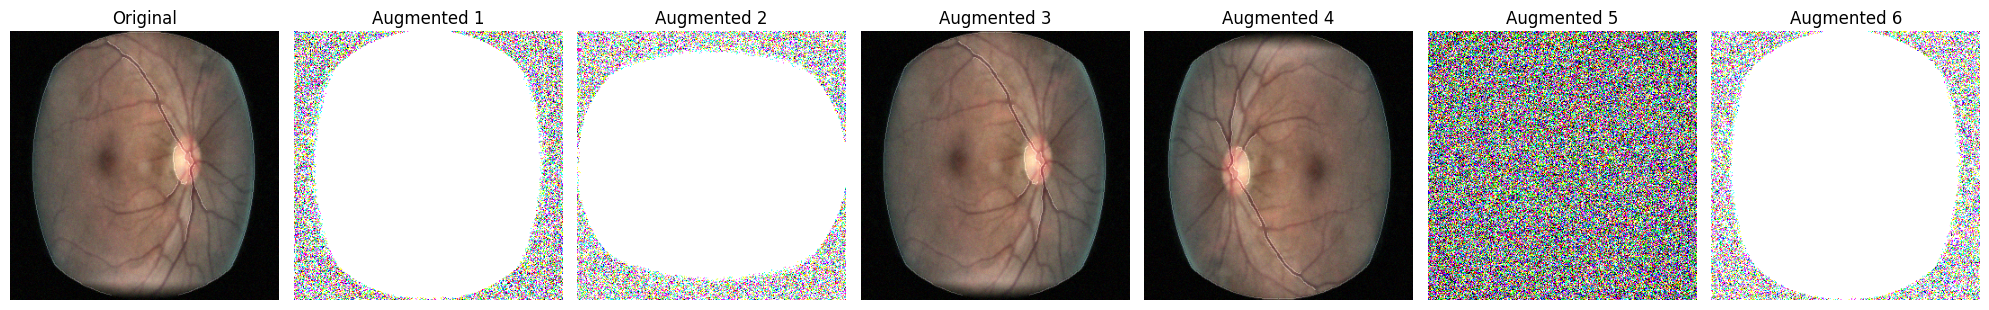

In [15]:
def show_augmentations(dataset, num_augmentations=6):
    idx = np.random.randint(len(dataset))
    original_img, label = dataset[idx]
    original_img = original_img.numpy().transpose(1, 2, 0)
    
    fig, axes = plt.subplots(1, num_augmentations + 1, figsize=(20, 4))
    axes[0].imshow((original_img - original_img.min()) / (original_img.max() - original_img.min()))
    axes[0].set_title("Original")
    axes[0].axis('off')
    
    for i in range(num_augmentations):
        augmented = dataset.transform(image=original_img)['image']
        augmented = (augmented - augmented.min()) / (augmented.max() - augmented.min())
        axes[i+1].imshow(augmented)
        axes[i+1].set_title(f"Augmented {i+1}")
        axes[i+1].axis('off')
    
    plt.tight_layout()
    plt.show()

print("Augmentation Examples:")
show_augmentations(train_dataset)

## Model Training using EfficientNet-B3

In [16]:
# Define the ResNet18 model
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 5)  # 5 is the number of classes in the dataset

# Move the model to the appropriate device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else 
                      "mps" if torch.backends.mps.is_available() else 
                      "cpu")
model = model.to(device)

/Users/shaunliew/Documents/t4g-ml/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/shaunliew/Documents/t4g-ml/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/shaunliew/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 46.0MB/s]


In [18]:
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

In [19]:
def train_with_wandb(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs, device):
    wandb.init(project="diabetic-retinopathy", name="efficientnet-b3")
    
    wandb.config.update({
        "learning_rate": optimizer.param_groups[0]['lr'],
        "epochs": num_epochs,
        "batch_size": train_loader.batch_size,
        "model": model.__class__.__name__,
    })

    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train
        
        # Validation
        model.eval()
        correct = 0
        total = 0
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_loss = val_loss / len(test_loader)
        accuracy = 100 * correct / total

        scheduler.step(val_loss)

        wandb.log({
            "epoch": epoch,
            "train_loss": epoch_loss,
            "train_accuracy": train_accuracy,
            "val_loss": val_loss,
            "val_accuracy": accuracy,
            "learning_rate": optimizer.param_groups[0]['lr']
        })

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Accuracy: {accuracy:.2f}%')

    print('Finished Training')
    wandb.finish()

KeyboardInterrupt: 

In [ ]:
num_epochs = 30
train_with_wandb(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs, device)

In [ ]:
# Save the model    
torch.save(model.state_dict(), 'diabetic_retinopathy_model.pth')

In [ ]:
# Evaluate the model
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(all_labels, all_preds, target_names=[LABEL_MAPPING[i] for i in range(5)]))
print(confusion_matrix(all_labels, all_preds))

In [ ]:
# Plot the confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[LABEL_MAPPING[i] for i in range(5)], 
            yticklabels=[LABEL_MAPPING[i] for i in range(5)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()